# Objetivo

En este trabajo comparto el código de  tres funciones que nos permiten bajar datos de tres de los más importantes repositorios de datos de este mercado:

* esios : https://www.esios.ree.es/es?locale=es
* REDData API: https://www.ree.es/es/apidatos
* MibGas : https://www.mibgas.es/es


La información disponible en cada uno de ellos es muy vasta. En este ejercicio jugaremos con algunos ejemplos en cada una de las APIs...

Vamos con ello...

# Importamos librerías

In [1]:
import pandas as pd
import numpy as np
import requests
import json
from datetime import datetime,timedelta,date
import sys



import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import cm
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import (YEARLY, MONTHLY, DateFormatter, WeekdayLocator, MonthLocator,DayLocator,
                              rrulewrapper, RRuleLocator, drange, num2date, date2num)
import matplotlib.patches as mpatches
import matplotlib.units as munits
from matplotlib.dates import num2date, date2num

import seaborn as sns


from html.parser import HTMLParser
import html

sys.path.append("/Users/mharias/Documents/proyectos/mylibs") # directorio de acceso a librerías auxiliares

from pass_esios import token_esios #importo mi token de esios, añadan su propia clave en su versión

# Funciones para bajar los datos

In [2]:
def catalogo_esios(token):
    """
    Descarga todos los identificadores y su descripcion de esios
    
    Parameters
    ----------
    token : str
        El token de esios necesario para realizar las llamadas al API
        
    Returns
    -------
    DataFrame
        Dataframe de pandas con el catalogo de los id de la API
    
    """
    
    
    headers = {'Accept':'application/json; application/vnd.esios-api-v2+json',
           'Content-Type':'application/json',
           'Host':'api.esios.ree.es',
           'Cookie' : '',
           'Authorization':'Token token={}'.format(token),
           'Cache-Control': 'no-cache',
           'Pragma': 'no-cache'
          }
    end_point = 'https://api.esios.ree.es/indicators'
    response = requests.get(end_point, headers=headers).json()
    
    #del resultado en json bruto se convierte en pandas, y se eliminan los tags del campo description

    return (pd
            .json_normalize(data=response['indicators'], errors='ignore')
            .assign(description = lambda df_: df_.apply(lambda df__: html.unescape(df__['description']
                                                            .replace('<p>','')
                                                            .replace('</p>','')
                                                            .replace('<b>','')
                                                            .replace('</b>','')), 
                                                  axis=1)
                   )
           )

In [3]:
def download_esios(token,indicadores,fecha_inicio,fecha_fin,time_trunc='day'):
    """
    Descarga datos esios desde un determinado identidficador y entre dos fechas
    
    Parameters
    ----------
    token : str
        El token de esios necesario para realizar las llamadas al API
    
    indicadores : list
        Lista con los strings de los indicadores de los que queremos bajar datos
        
    fecha_inicio : str
        Fecha con formato %Y-%M-%d, que indica la fecha desde la que se quiere bajar los datos.
        Ejemplo 2022-10-30, 30 Octubre de 2022.
    
    fecha_fin : str
        Fecha con formato %Y-%M-%d, que indica la fecha hasta la que se quiere bajar los datos.
        Ejemplo 2022-10-30, 30 Octubre de 2022.
        
    time_trunc : str, optional
        Campo adicional que nos permite elegir la granularidad de los datos que queremos bajar.
        
    Returns
    -------
    DataFrame
        Dataframe de pandas con los datos solicitados
    
    """
    
    # preparamos la cabecera a insertar en la llamada. Vease la necesidad de disponer el token de esios
    
    headers = {'Accept':'application/json; application/vnd.esios-api-v2+json',
           'Content-Type':'application/json',
           'Host':'api.esios.ree.es',
           'Cookie' : '',
           'Authorization':'Token token={}'.format(token),
           'Cache-Control': 'no-cache',
           'Pragma': 'no-cache'
          }
    
    # preparamos la url básica a la que se le añadiran los campos necesarios 
    
    end_point = 'https://api.esios.ree.es/indicators'
    
    # El procedimiento es sencillo: 
    # a) por cada uno de los indicadores configuraremos la url, según las indicaciones de la documentación.
    # b) Hacemos la llamada y recogemos los datos en formato json.
    # c) Añadimos la información a una lista
    
    lista=[]

    for indicador in indicadores:
        url = f'{end_point}/{indicador}?start_date={fecha_inicio}T00:00&\
        end_date={fecha_fin}T23:59&time_trunc={time_trunc}'
        print (url)
        response = requests.get(url, headers=headers).json()
        lista.append(pd.json_normalize(data=response['indicator'], record_path=['values'], meta=['name','short_name'], errors='ignore'))

    # Devolvemos como salida de la función un df fruto de la concatenación de los elemenos de la lista
    # Este procedimiento, con una sola concatenación al final, es mucho más eficiente que hacer múltiples 
    # concatenaciones.
    
    return pd.concat(lista, ignore_index=True )

In [4]:
def download_ree(indicador,fecha_inicio,fecha_fin,time_trunc='day'):
    """
    Descarga datos desde apidatos.ree.es entre dos fechas determinadas 
    
    Parameters
    ----------
    
    indicador : str
        Texto con el indicador del end point del que queremo bajar la información
        
    fecha_inicio : str
        Fecha con formato %Y-%M-%d, que indica la fecha desde la que se quiere bajar los datos.
        Ejemplo 2022-10-30, 30 Octubre de 2022.
    
    fecha_fin : str
        Fecha con formato %Y-%M-%d, que indica la fecha hasta la que se quiere bajar los datos.
        Ejemplo 2022-10-30, 30 Octubre de 2022.
        
    time_trunc : str, optional
        Campo adicional que nos permite elegir la granularidad de los datos que queremos bajar.
        Hour, Day, Month...dependiendo del end point se aplicará o no esta orden
        
    Returns
    -------
    DataFrame
        Dataframe de pandas con los datos solicitados
    
    """
    
    
    headers = {'Accept': 'application/json',
               'Content-Type': 'applic<ation/json',
               'Host': 'apidatos.ree.es'}
    
    end_point = 'https://apidatos.ree.es/es/datos/'
    
    lista=[]
    url = f'{end_point}{indicador}?start_date={fecha_inicio}T00:00&end_date={fecha_fin}T23:59&\
    time_trunc={time_trunc}'
    print (url)
    
    response = requests.get(url, headers=headers).json()
    
    return pd.json_normalize(data=response['included'], 
                                   record_path=['attributes','values'], 
                                   meta=['type',['attributes','type' ]], 
                                   errors='ignore')

In [5]:
def download_gas(year):
    """
    Descarga datos de precio de gas desde MIBGAS para GDAES
    
    Parameters
    ----------
    year : str
        Indicamos el año del que nos queremos bajar los datos de precio de gas PVB
        
    Returns
    -------
    DataFrame
        Dataframe de pandas con los datos solicitados, columnas Fecha , Producto y Precio
    
    """
    
    path = f'https://www.mibgas.es/en/file-access/MIBGAS_Data_{year}.xlsx?path=AGNO_{year}/XLS'
    return (pd.read_excel(path,sheet_name='Trading Data PVB&VTP',usecols=['Trading day','Product','Daily Reference Price\n[EUR/MWh]']).
       query("Product=='GDAES_D+1'").
       rename(columns={'Trading day':'fecha','Product':'Producto','Daily Reference Price\n[EUR/MWh]':'precio'}).
       sort_values('fecha',ascending=True).
       reset_index(drop=True)
      )

In [6]:
def download_gas_rd(year):
    """
    Descarga datos de precio de gas desde MIBGAS para compensación segñun RD10/2022
    
    Parameters
    ----------
    YEAR : str
        Indicamos el año del que nos queremos bajar los datos de precio de gas de RD10/22
        
    Returns
    -------
    DataFrame
        Dataframe de pandas con los datos solicitados, columnas Fecha , Producto y Precio
    
    """
    
    path = f'https://www.mibgas.es/en/file-access/MIBGAS_Data_{year}.xlsx?path=AGNO_{year}/XLS'
    return (pd.read_excel(path,sheet_name='PGN_RD_10_2022',
                          usecols=['Date','PGN Price\n[EUR/MWh]']).
       rename(columns={'Date':'fecha','PGN Price\n[EUR/MWh]':'precio'}).
       sort_values('fecha',ascending=True).
       reset_index(drop=True)
      )

      

# Esios

## Preparamos un catálogo

Empezamos con la función `catalogo_esios(token)` con la que generamos un pandas con todos los endpoints de esta API.

In [7]:
catalogo = catalogo_esios(token_esios)

In [8]:
catalogo.head()

,name,description,id
0,Número de activaciones,Número de activaciones,1928
1,RD-L 10/2022 mercado diario e intradiario - Anual,RD-L 10/2022 mercado diario e intradiario - Anual,10409
2,RD-L 10/2022 restricciones técnicas y mercados...,RD-L 10/2022 restricciones técnicas y mercados...,10411
3,RD-L 10/2022 mercado diario e intradiario - di...,RD-L 10/2022 mercado diario e intradiario - di...,10410
4,RD-L 10/2022 mercado diario e intradiario - Me...,RD-L 10/2022 mercado diario e intradiario - Me...,10406


podemos buscar los identificadores de las fuentes que nos interesan. Busquemos, como ejemplo, aquellas relacionadas con energía nuclear:

In [9]:
for i in catalogo.loc[catalogo['name'].str.contains('uclear'),:].index:
       print (f"{catalogo.loc[i,'id']} -> {catalogo.loc[i,'name']}")

1477 -> Potencia instalada de generación nuclear
1403 -> Generación programada PHFC Nuclear
1153 -> Generación medida Nuclear
549 -> Generación T.Real nuclear
482 -> Potencia disponible de generación Nuclear horizonte año móvil
474 -> Potencia disponible de generación Nuclear horizonte horario
466 -> Potencia instalada de generación convencional Nuclear
424 -> Programa bilateral PBF Nuclear
319 -> Generación programada PHF7 Nuclear
284 -> Generación programada PHF6 Nuclear
249 -> Generación programada PHF5 Nuclear
214 -> Generación programada PHF4 Nuclear
179 -> Generación programada PHF3 Nuclear
144 -> Generación programada PHF2 Nuclear
109 -> Generación programada PHF1 Nuclear
74 -> Generación programada P48 Nuclear
39 -> Generación programada PVP Nuclear
4 -> Generación programada PBF Nuclear


Hemos utilizado como palabra clave `uclear` para que sea indiferente si va en mayúscula o en minúscula

También podemos hacer una búsqueda teniendo ya el identificador. Eso nos facilita el buscar los identificadores que nos proporcionan la información para generar ciertas gráficas de esios. Como ejemplo: 

https://www.esios.ree.es/es/analisis/1293?vis=1&start_date=04-11-2022T00%3A00&end_date=04-11-2022T23%3A55&compare_start_date=03-11-2022T00%3A00&groupby=minutes5&compare_indicators=545,544

Esta gráfica, como podemos observa en la url, se genera con el ID=1293, y se compara con la 544 y 545.

In [10]:
identificadores = [544,545,1293]

In [11]:
for id in identificadores:
 print(f"{catalogo.loc[catalogo['id']==id,'id'].values[0]}-->{catalogo.loc[catalogo['id']==id,'name'].values[0]}\
-{catalogo.loc[catalogo['id']==id,'description'].values[0]}"+'\n')

544-->Demanda prevista-

Es la previsión de consumo que REE elabora teniendo en cuenta los valores de consumo registrados en periodos precedentes similares, así como otros factores con influencia en el consumo eléctrico como la laboralidad, la climatología y la actividad económica. Los valores diezminutales son representandos en forma de curva aplicando unos parámetros que parabolizan el valor constante horario.

Publicación: diariamente a las 0:00 horas con la información del día D y a las 13:30 horas con las tres primeras horas del día D+1. Un valor cada diez minutos.


545-->Demanda programada-Es la demanda de energía programada calculada mediante los intercambios internacionales programados y los programas de los grupos de generación a los que se les haya asignado suministro de energía en la casación de los mercados diario e intradiario, así como en los mercados de energías de balance RR y regulación terciaria. Estos dos últimos son gestionados por REE teniendo en cuenta la evoluci

Y ahí tenemos los datos. Y podemos bajar los datos de estos dos últimos días

## Bajamos datos de algunos identificadores

In [13]:
fin = datetime.today().strftime('%Y-%m-%d')  # string con la fecha de hoy en el formato requerido por funcion
inicio = (datetime.today()-timedelta(days=2)).strftime('%Y-%m-%d')

In [14]:
datos_raw = download_esios(token_esios, identificadores, inicio, fin, time_trunc='five_minutes' )

https://api.esios.ree.es/indicators/544?start_date=2022-11-04T00:00&        end_date=2022-11-06T23:59&time_trunc=five_minutes
https://api.esios.ree.es/indicators/545?start_date=2022-11-04T00:00&        end_date=2022-11-06T23:59&time_trunc=five_minutes
https://api.esios.ree.es/indicators/1293?start_date=2022-11-04T00:00&        end_date=2022-11-06T23:59&time_trunc=five_minutes


In [15]:
datos_raw

,value,datetime,datetime_utc,tz_time,geo_id,geo_name,name,short_name
0,23046.0,2022-11-04T00:00:00.000+01:00,2022-11-03T23:00:00Z,2022-11-03T23:00:00.000Z,8741,Península,Demanda prevista,Demanda prevista
1,22981.0,2022-11-04T00:05:00.000+01:00,2022-11-03T23:05:00Z,2022-11-03T23:05:00.000Z,8741,Península,Demanda prevista,Demanda prevista
2,22899.0,2022-11-04T00:10:00.000+01:00,2022-11-03T23:10:00Z,2022-11-03T23:10:00.000Z,8741,Península,Demanda prevista,Demanda prevista
3,22800.0,2022-11-04T00:15:00.000+01:00,2022-11-03T23:15:00Z,2022-11-03T23:15:00.000Z,8741,Península,Demanda prevista,Demanda prevista
4,22694.0,2022-11-04T00:20:00.000+01:00,2022-11-03T23:20:00Z,2022-11-03T23:20:00.000Z,8741,Península,Demanda prevista,Demanda prevista
...,...,...,...,...,...,...,...,...
2431,21132.0,2022-11-06T10:35:00.000+01:00,2022-11-06T09:35:00Z,2022-11-06T09:35:00.000Z,8741,Península,Demanda real,Demanda real
2432,21122.0,2022-11-06T10:40:00.000+01:00,2022-11-06T09:40:00Z,2022-11-06T09:40:00.000Z,8741,Península,Demanda real,Demanda real
2433,21153.0,2022-11-06T10:45:00.000+01:00,2022-11-06T09:45:00Z,2022-11-06T09:45:00.000Z,8741,Península,Demanda real,Demanda real
2434,21229.0,2022-11-06T10:50:00.000+01:00,2022-11-06T09:50:00Z,2022-11-06T09:50:00.000Z,8741,Península,Demanda real,Demanda real


In [16]:
datos_raw['short_name'].unique()

array(['Demanda prevista', 'Demanda programada', 'Demanda real'],
      dtype=object)

En este pandas tenemos todos los datos todos los datos de estos tres identificadores..Es importante un detalle que aparece en las descripciones de los tres identificadores: se refieren a 10 minutos, pero la granularidad con la que se presentan los datos es con un período de 5 minutos, es por ello que hemos indicado el`time_trunc = five_minutes`. Este texto `five_minutes` se indica en las paginas de ayuda de la API: 

https://api.esios.ree.es/indicator/getting_a_disaggregated_indicator_filtering_values_by_a_date_range_and_geo_ids,_grouped_by_geo_id_and_month,_using_avg_aggregation_for_geo_and_avg_for_time_without_time_trunc

Personalmente me gusta reformatear el pandas, con nombre de columnas estandares y eliminando las que no voy a usar:

In [17]:
datos = (datos_raw
         .assign(fecha=lambda df_: pd #formateamos campo fecha, desde un str con diferencia horaria a un naive
                      .to_datetime(df_['datetime'],utc=True)  # con la fecha local
                      .dt
                      .tz_convert('Europe/Madrid')
                      .dt
                      .tz_localize(None)
                ) 
             .drop(['datetime','datetime_utc','tz_time','geo_id','geo_name','short_name'],
                   axis=1) #eliminamos campos
             .loc[:,['fecha','name','value']]
             )
        

In [18]:
datos

,fecha,name,value
0,2022-11-04 00:00:00,Demanda prevista,23046.0
1,2022-11-04 00:05:00,Demanda prevista,22981.0
2,2022-11-04 00:10:00,Demanda prevista,22899.0
3,2022-11-04 00:15:00,Demanda prevista,22800.0
4,2022-11-04 00:20:00,Demanda prevista,22694.0
...,...,...,...
2431,2022-11-06 10:35:00,Demanda real,21132.0
2432,2022-11-06 10:40:00,Demanda real,21122.0
2433,2022-11-06 10:45:00,Demanda real,21153.0
2434,2022-11-06 10:50:00,Demanda real,21229.0


y ya los tenemos disponibles para montar la gráfica:

Text(0.7, 0.0, '@walyt')

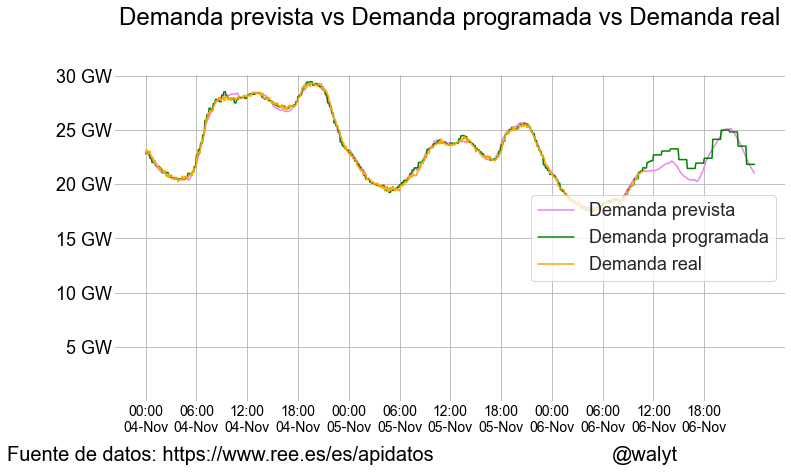

In [19]:
titulo = f'Demanda prevista vs Demanda programada vs Demanda real'
fuente = 'https://www.ree.es/es/apidatos'
autor='@walyt'

f, ax = plt.subplots(figsize=(12,6))
sns.set_style(style='white')
paleta = ['violet','green','orange']

sns.lineplot(
     data=datos,
     x='fecha', 
     y='value',
     ci=None,
     estimator=sum,
     hue='name',
     ax=ax,
     linewidth=1.5,
     palette=paleta
     )

ax.legend(loc=7,fontsize=18)

ax.xaxis.set_tick_params(labelsize=14,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=18,width=0,rotation=0,pad=-0)

ax.set_ylim(bottom=9)
ax.set_xlabel('')
ax.set_ylabel('')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v/1000:,.0f} GW')) # los datos están en MW
ax.set_xticks(datos['fecha'].unique()[::72]) #6 horas de espaciado en eje X son 6*12 periodos de 5 min
ax.set_xticklabels([pd.to_datetime(i).strftime('%H:%M\n%d-%b') for i in datos['fecha'].unique()[::72]])
sns.despine(left=True, bottom=True)
ax.grid(True)

#Título
ax.set_title('{}'.format(titulo),fontsize=24,color='black',pad=50,y=1.0)

#Indicaciones inferior
f.text(0.0, 0.0, 'Fuente de datos: {}'.format(fuente), horizontalalignment='left',
             verticalalignment='center', fontsize=20,color='black')
f.text(0.7,0.00,'{}'.format(autor),
                 verticalalignment='center',fontsize=20,horizontalalignment='left',color='black')




que es la misma gráfica que encontramos en el link que hemos referenciado anteriormente.

# Datos desde https://www.ree.es/es/apidatos

En el link del título tenemos la descripción del servicio `REST` para acceder a la API. Siguiendo esas instrucciones montamos la funcion `download_ree` para que de manera fácil podamos bajar la información que disponemos.

Veamos un ejemplo práctico bajando la generación, con sus diferentes tipos:

In [20]:
fin = datetime.today().strftime('%Y-%m-%d')  # string con la fecha de hoy en el formato requerido por funcion
inicio = (datetime.today()-timedelta(days=7)).strftime('%Y-%m-%d')
identificador = 'generacion/estructura-generacion'

In [21]:
raw = download_ree(identificador,inicio,fin)

https://apidatos.ree.es/es/datos/generacion/estructura-generacion?start_date=2022-10-30T00:00&end_date=2022-11-06T23:59&    time_trunc=day


Veamos un ejemplo de los datos descargados:

In [22]:
raw.sample()

,value,percentage,datetime,type,attributes.type
63,66364.899,0.104941,2022-11-02T00:00:00.000+01:00,Solar fotovoltaica,Renovable


Tal como hicimos en el caso anterior vamos a formatear los datos en bruto para sacar la tabla que queremos:

In [23]:
raw.dtypes

value              float64
percentage         float64
datetime            object
type                object
attributes.type     object
dtype: object

In [24]:
generacion = (raw
              .assign(fecha=lambda df_: pd
                      .to_datetime(df_['datetime'],utc=True)
                      .dt
                      .tz_convert('Europe/Madrid')
                      .dt
                      .tz_localize(None)
                      )
              .query('type in ["Nuclear","Solar fotovoltaica","Eólica","Hidráulica"]')
              .drop(['attributes.type','datetime','percentage'],axis=1)
              .rename(columns={'value':'valor','type':'tipo','value':'generacion'})[['fecha','tipo','generacion']]
            )

y nos queda tal que así

In [25]:
generacion

,fecha,tipo,generacion
0,2022-10-30,Hidráulica,31237.000
1,2022-10-31,Hidráulica,32717.000
2,2022-11-01,Hidráulica,29986.500
3,2022-11-02,Hidráulica,35251.500
4,2022-11-03,Hidráulica,34890.100
5,2022-11-04,Hidráulica,31460.800
12,2022-10-30,Nuclear,124157.700
13,2022-10-31,Nuclear,119352.500
14,2022-11-01,Nuclear,119300.100
15,2022-11-02,Nuclear,119241.500


..y los utilizamos para generar un gráfico de barras que nos muestras la evolución de la generación, por cada fuente, en estos días:

Text(0.7, 0.0, '@walyt')

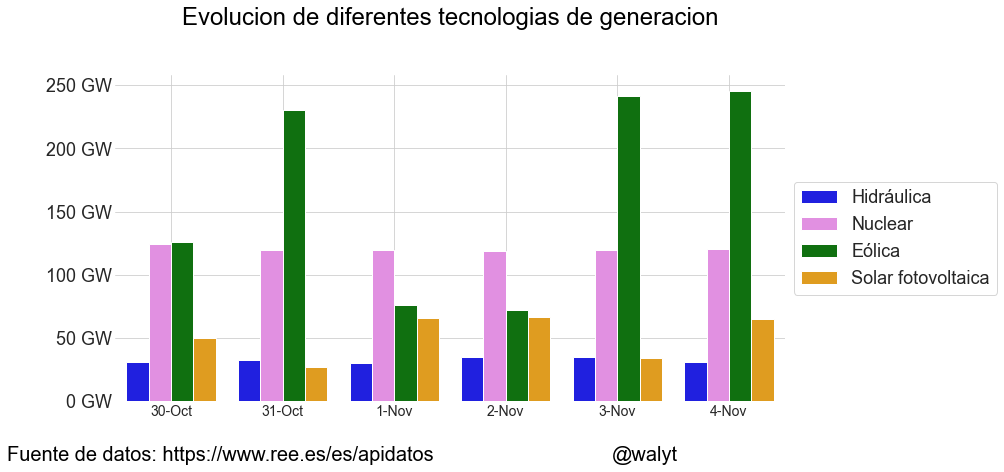

In [26]:
titulo = f'Evolucion de diferentes tecnologias de generacion'
fuente = 'https://www.ree.es/es/apidatos'
autor='@walyt'

f, ax = plt.subplots(figsize=(12,6))
sns.set_style(style='white')
paleta = ['blue','violet','green','orange']

sns.barplot(
     data=generacion,
     x='fecha', 
     y='generacion',
     ci=None,
     estimator=sum,
     hue='tipo',
     ax=ax,
     palette=paleta
     )

ax.legend(loc='center left',fontsize=18,bbox_to_anchor=(1, 0.5))

ax.xaxis.set_tick_params(labelsize=14,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=18,width=0,rotation=0,pad=-0)

ax.set_ylim(bottom=0)
ax.set_xlabel('')
ax.set_ylabel('')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v/1000:,.0f} GW')) # los datos están en MW

ax.set_xticklabels([i.strftime('%-d-%b') for i in pd.to_datetime(generacion['fecha'].unique())])

sns.despine(left=True, bottom=True)
ax.grid(True)

#Título
ax.set_title('{}'.format(titulo),fontsize=24,color='black',pad=50,y=1.0)

#Indicaciones inferior
f.text(0.0, 0.0, 'Fuente de datos: {}'.format(fuente), horizontalalignment='left',
             verticalalignment='center', fontsize=20,color='black')
f.text(0.7,0.00,'{}'.format(autor),
                 verticalalignment='center',fontsize=20,horizontalalignment='left',color='black')




# Descarga de datos de gas GDAES

Le toca el turno al gas, {ironía ON} el culpable de todos nuestros males {ironía OFF}. [MIBGAS](https://www.mibgas.es/es) ofrece una amplia variedad de datos, y como ejemplo he preparado dos funciones muy simples para bajar datos con el precio de gas PVB ([Punto Virtual de Balance](https://www.boe.es/buscar/doc.php?id=BOE-A-2020-682) ) y con el precio de gas utilizado para el cálculo de la famosa compensación de gas por el [Real Decreto 10/2022](https://www.boe.es/buscar/act.php?id=BOE-A-2022-7843). 

Empezamos con el primero, a la función tan solo hay que pasarle el año que queremos bajar. Este formato de descarga viene impuesto por la manera que tiene Mibgas de entregar está información, agrupada en ficheros excel por año: [ficheros excel de Mibgas](https://www.mibgas.es/es/file-access)

In [27]:
gas = download_gas(2022)

In [28]:
gas.head()

,fecha,Producto,precio
0,2022-01-01,GDAES_D+1,53.17
1,2022-01-02,GDAES_D+1,57.72
2,2022-01-03,GDAES_D+1,73.58
3,2022-01-04,GDAES_D+1,88.17
4,2022-01-05,GDAES_D+1,90.20


Vemos que esta tabla ya está formateada con lo que podemos empezar a trabajar directamente con ellos. Preparemos una gráfica scatterplot con los datos desde 15 Junio cuando se puso en marcha el nuevo modelo de oferta de gas topado:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.7, 0.0, '@walyt')

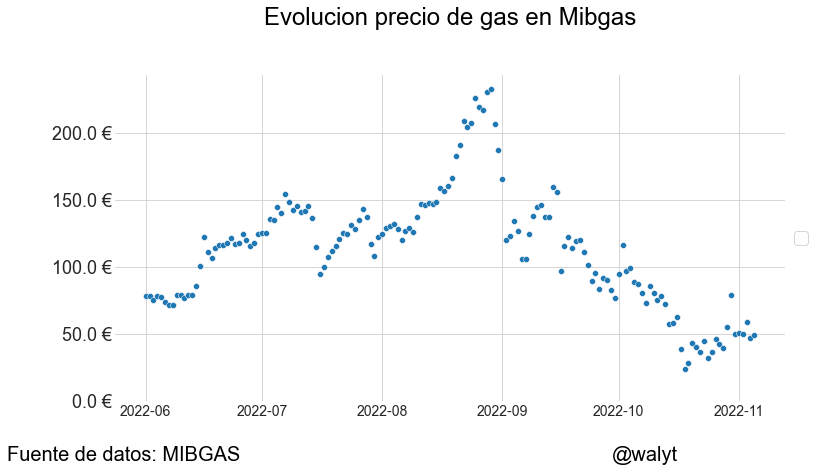

In [29]:
titulo = f'Evolucion precio de gas en Mibgas'
fuente = 'MIBGAS'
autor='@walyt'

f, ax = plt.subplots(figsize=(12,6))
sns.set_style(style='white')
paleta = ['blue','violet','green','orange']

sns.scatterplot(
     data=gas.loc[gas['fecha']>='2022-06-01',:],
     x='fecha', 
     y='precio',
     ci=None,
     estimator=sum,
     ax=ax,
     palette=paleta
     )

ax.legend(loc='center left',fontsize=18,bbox_to_anchor=(1, 0.5))

ax.xaxis.set_tick_params(labelsize=14,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=18,width=0,rotation=0,pad=-0)

ax.set_ylim(bottom=0)
ax.set_xlabel('')
ax.set_ylabel('')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v:,.1f} €')) # los datos están en MW

#ax.set_xticklabels([i.strftime('%-d-%b') for i in pd.to_datetime(generacion['fecha'].unique())])

sns.despine(left=True, bottom=True)
ax.grid(True)

#Título
ax.set_title('{}'.format(titulo),fontsize=24,color='black',pad=50,y=1.0)

#Indicaciones inferior
f.text(0.0, 0.0, 'Fuente de datos: {}'.format(fuente), horizontalalignment='left',
             verticalalignment='center', fontsize=20,color='black')
f.text(0.7,0.00,'{}'.format(autor),
                 verticalalignment='center',fontsize=20,horizontalalignment='left',color='black')




# Precio de gas RD10/2022

Y ahora haremos lo mismo con los datos de la referencia del precio de compensación de gas, que Mibgas publica cada mañana antes de las 10:00 según se regula en el correspondiente [RD](https://www.boe.es/buscar/act.php?id=BOE-A-2022-7843).

La función está preparada de manera análoga a la anterior : 

In [30]:
gas_rd = download_gas_rd(2022)

In [31]:
gas_rd

,fecha,precio
0,2022-06-15,80.00
1,2022-06-16,97.54
2,2022-06-17,106.94
3,2022-06-18,109.67
4,2022-06-19,106.33
...,...,...
141,2022-11-03,41.38
142,2022-11-04,51.81
143,2022-11-05,56.88
144,2022-11-06,44.27


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.7, 0.0, '@walyt')

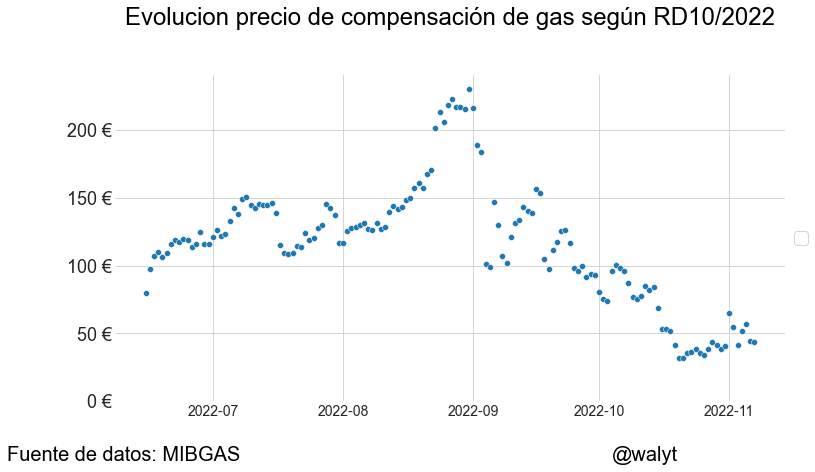

In [32]:
titulo = f'Evolucion precio de compensación de gas según RD10/2022'
fuente = 'MIBGAS'
autor='@walyt'

f, ax = plt.subplots(figsize=(12,6))
sns.set_style(style='white')
paleta = ['blue','violet','green','orange']

sns.scatterplot(
     data=gas_rd,
     x='fecha', 
     y='precio',
     ci=None,
     estimator=sum,
     ax=ax,
     palette=paleta
     )

ax.legend(loc='center left',fontsize=18,bbox_to_anchor=(1, 0.5))

ax.xaxis.set_tick_params(labelsize=14,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=18,width=0,rotation=0,pad=-0)

ax.set_ylim(bottom=0)
ax.set_xlabel('')
ax.set_ylabel('')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v:,.0f} €')) # los datos están en MW

#ax.set_xticklabels([i.strftime('%-d-%b') for i in pd.to_datetime(generacion['fecha'].unique())])

sns.despine(left=True, bottom=True)
ax.grid(True)

#Título
ax.set_title('{}'.format(titulo),fontsize=24,color='black',pad=50,y=1.0)

#Indicaciones inferior
f.text(0.0, 0.0, 'Fuente de datos: {}'.format(fuente), horizontalalignment='left',
             verticalalignment='center', fontsize=20,color='black')
f.text(0.7,0.00,'{}'.format(autor),
                 verticalalignment='center',fontsize=20,horizontalalignment='left',color='black')




y para terminar, y como curiosidad, podemos preparar un gráfico con las dos series: gas GDAES y este último de compensación:

Text(0.7, 0.0, '@walyt')

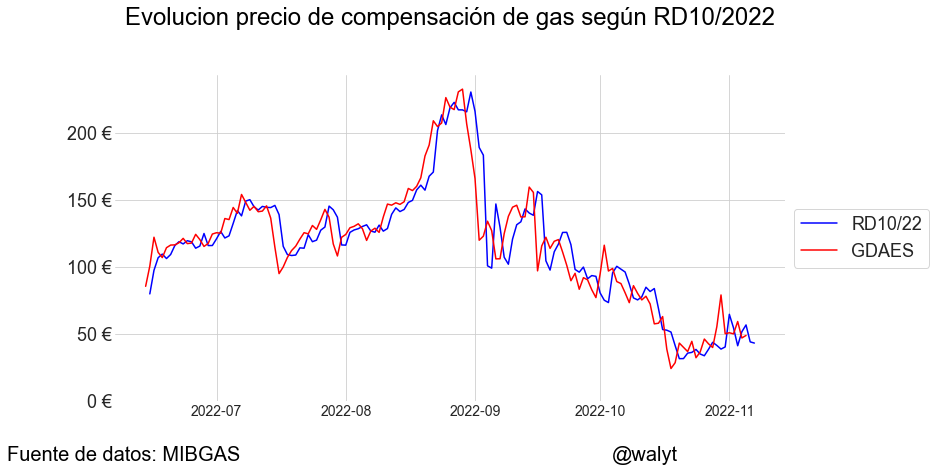

In [33]:
titulo = f'Evolucion precio de compensación de gas según RD10/2022'
fuente = 'MIBGAS'
autor='@walyt'

f, ax = plt.subplots(figsize=(12,6))
sns.set_style(style='white')

sns.lineplot(
     data=gas_rd,
     x='fecha', 
     y='precio',
     ci=None,
     estimator=sum,
     ax=ax,
    color='blue',label='RD10/22'
     )

sns.lineplot(
     data=gas.loc[gas['fecha']>='2022-06-14',:],
     x='fecha', 
     y='precio',
     ci=None,
     estimator=sum,
     ax=ax,
    color='red',label='GDAES'
     )

ax.legend(loc='center left',fontsize=18,bbox_to_anchor=(1, 0.5))

ax.xaxis.set_tick_params(labelsize=14,width=0,rotation=0,pad=0)
ax.yaxis.set_tick_params(labelsize=18,width=0,rotation=0,pad=-0)

ax.set_ylim(bottom=0)
ax.set_xlabel('')
ax.set_ylabel('')

ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda v,x:f'{v:,.0f} €')) # los datos están en MW

#ax.set_xticklabels([i.strftime('%-d-%b') for i in pd.to_datetime(generacion['fecha'].unique())])

sns.despine(left=True, bottom=True)
ax.grid(True)

#Título
ax.set_title('{}'.format(titulo),fontsize=24,color='black',pad=50,y=1.0)

#Indicaciones inferior
f.text(0.0, 0.0, 'Fuente de datos: {}'.format(fuente), horizontalalignment='left',
             verticalalignment='center', fontsize=20,color='black')
f.text(0.7,0.00,'{}'.format(autor),
                 verticalalignment='center',fontsize=20,horizontalalignment='left',color='black')